### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

Построить модель градиентного бустинга для классификации числа страховых случаев (см. в конце ноутбука). Можно предобработать исходные данные, добавив дополнительные фичи. Также можно использовать различные методы для подбора гиперпараметров. Оценить результаты построенного классификатора, выявить возможные проблемы. Сравнить результаты с полученным на занятии результатом с использованием Пуассоновской регрессии. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [4]:
# обнулить отрицательный ущерб
df.loc[df['ClaimAmount'] < 0, 'ClaimAmount'] = 0

# перекодировать признаки
df['MariStat'], MariStatRef = SeriesFactorizer(df['MariStat'])
df['Gender'], GenderRef = SeriesFactorizer(df['Gender'])

# перекодировать SocioCateg до первой значащей цифры класса 
df['SocioCateg'] = df['SocioCateg'].str.slice(0,4)

# дамми
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

# удалить лишние признаки
df = df.select_dtypes(exclude=['object'])

df['DrivAgeSq'] = df['DrivAge'].apply(lambda x: x**2)

{0: 'Other', 1: 'Alone'}
{0: 'Male', 1: 'Female'}


In [5]:
df['ClaimsCount'] = df['ClaimInd'] + df['ClaimNbResp'] + df['ClaimNbNonResp'] + df['ClaimNbParking'] + df['ClaimNbFireTheft'] + df['ClaimNbWindscreen']
df.loc[df['ClaimAmount'] == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [8]:
df.loc[df['ClaimsCount']==11,'ClaimsCount']=10
df['ClaimsCount'].value_counts()

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`. Для полученных значений также посчитаем нормированную частоту.

In [9]:
FreqCount = pd.DataFrame(df['ClaimsCount'].value_counts()).rename(columns={'ClaimsCount':'Count'})
FreqCount['Freq'] = FreqCount['Count']/FreqCount['Count'].sum()
FreqCount

,Count,Freq
0.0,104286,0.905614
2.0,3529,0.030646
1.0,3339,0.028996
3.0,2310,0.020060
4.0,1101,0.009561
5.0,428,0.003717
6.0,127,0.001103
7.0,26,0.000226
8.0,6,0.000052
9.0,2,0.000017


In [10]:
dict(FreqCount['Freq'])

{0.0: 0.9056141722026834,
 2.0: 0.030645651513177892,
 1.0: 0.028995701445877296,
 3.0: 0.02005991923928618,
 4.0: 0.009561026442620815,
 5.0: 0.0037167296252876556,
 6.0: 0.0011028613607746082,
 7.0: 0.00022578264078850245,
 8.0: 5.210368633580826e-05,
 9.0: 1.7367895445269418e-05,
 10.0: 8.683947722634709e-06}

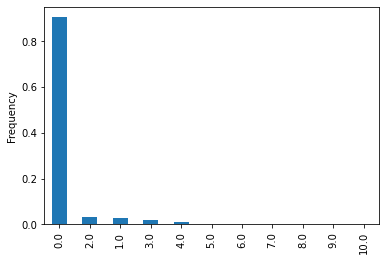

In [11]:
FreqCount['Freq'].plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [12]:
df['weight'] = df['ClaimsCount'].map(dict(1-FreqCount['Freq']))

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df['ClaimsCount'], test_size=0.3, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [14]:
xgb_train = xgb.DMatrix(data=x_train.drop(['Exposure','weight'], axis=1), label=y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop(['Exposure','weight'], axis=1), label=y_valid, weight=x_valid['weight'])
xgb_test  = xgb.DMatrix(data= x_test.drop(['Exposure','weight'], axis=1), label=y_test, weight=x_test['weight'])

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [15]:
# def xgb_eval(yhat, dtrain):
#     """
#     Function for Gamma Deviance evaluation
# 
#     :param yhat: np.ndarray object with predictions
#     :param dtrain: xgb.DMatrix object with target variable
#     :return: (str, float), tuple with metrics name and its value
#     """
#     y = dtrain.get_label()
#     return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [16]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    """
    Objective function for hyperopt. Optimizing mean cross-validation error with XGBoost.

    :param params: dict object passed to hyperopt fmin() function
    :return: float, mean cross-validation error for XGBoost utilizing params
    """
    params['max_depth'] = int(params['max_depth'])
    n_b_r = int(params.pop('num_boost_round'))
    data = params.pop('data')
    #feval = params.pop('feval')
    nfold = params.pop('nfold')
    e_s_r = params.pop('early_stopping_rounds')
    maximize = params.pop('maximize')
    
    cv_result = xgb.cv(params, data, num_boost_round=n_b_r, 
                       nfold=nfold, seed=0, maximize=maximize,
                       #feval = feval,
                       early_stopping_rounds=e_s_r)
    
    # name, _ = feval(data.get_label(), data)
    # score = cv_result[f'test-{name}-mean'][-1:].values[0]
    score = cv_result['test-mlogloss-mean'][-1:].values[0]
    return score

In [17]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'data': xgb_train,
              'objective': 'multi:softmax',
              #'feval': xgb_eval
              'eval_metric': 'mlogloss',
                  # merror – Multiclass classification error rate
                  # mlogloss – Multiclass logloss
              'maximize': False,
              'nfold': 2,
              'early_stopping_rounds': 20,
              'num_boost_round': 300,  # hp.choice('num_boost_round', [50, 300, 500])
              'max_depth': hp.choice('max_depth', [3, 5, 8, 10]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'num_class': FreqCount.shape[0]
              }

In [18]:
%%time

best = fmin(fn=objective, space=space_freq, algo=tpe.suggest, max_evals=50)

100%|██████████████████████████████████████████████████████████| 50/50 [26:50<00:00, 32.21s/trial, best loss: 1.453867]
Wall time: 26min 50s


In [19]:
# Оптимальные гиперпараметры 
best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.4547475158705355,
 'colsample_bytree': 0.5022163123698989,
 'data': <xgboost.core.DMatrix at 0x2421eb302e8>,
 'early_stopping_rounds': 20,
 'eta': 0.04144428135847503,
 'eval_metric': 'mlogloss',
 'lambda': 0.990972479758861,
 'max_depth': 3,
 'maximize': False,
 'min_child_weight': 18.945799055047342,
 'nfold': 2,
 'num_boost_round': 300,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.5609524463180161}

In [20]:
def train_xgb_best_params(params, dtrain, evals, early_stopping_rounds, evals_result=None, verbose_eval=None):
    """
    Function to train XGBoost estimator from set of parameters, passed from hyperopt.

    :param params: dict, hyperparameters from hyperopt space_eval() function
    :param dtrain: xgb.DMatrix object, to train model on
    :param evals: list of pairs (DMatrix, str). Same from xgb.train().
    :param early_stopping_rounds: int. Same from xgb.train().
    :param evals_result: dict. Same from xgb.train().
    :param verbose_eval: bool or int. Same from xgb.train().
    :return: xgb.Booster object, trained model
    """
    par = params.copy()
    for label in ['nfold', 'data', 'early_stopping_rounds']:
        del par[label]
    n_b_r = int(par.pop('num_boost_round'))
    maximize = par.pop('maximize')
    #feval = par.pop('feval')
    return xgb.train(params=par, dtrain=dtrain, num_boost_round=n_b_r, evals=evals, maximize=maximize,
                     early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=verbose_eval)


Далее обучим нашу модель с оптимальными параметрами

In [22]:
%%time
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = train_xgb_best_params(best_params, xgb_train, 
                                 [(xgb_train, "train"),(xgb_valid, "valid")], 
                                 early_stopping_rounds=20, evals_result=progress, 
                                 verbose_eval=False)


Wall time: 1min 25s


Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [23]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_freq.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score


F1 Score on train: 0.9039177252878127
F1 Score on valid: 0.9051120245469808
F1 Score on test: 0.9045965034155378


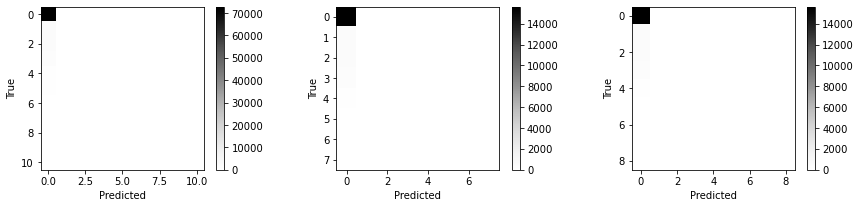

In [24]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_freq.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

In [26]:
from sklearn.metrics import classification_report
for i in range(len(dfsets)):
    predict = xgb_freq.predict(dfsets[i]['dmat'])
    print(dfsets[i]['set'])
    print(classification_report(dfsets[i]['target'], predict))
    print(confusion_matrix(dfsets[i]['target'], predict))
    print('*'*54)

train
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     72973
         1.0       0.10      0.00      0.01      2321
         2.0       0.00      0.00      0.00      2512
         3.0       0.19      0.01      0.01      1622
         4.0       0.00      0.00      0.00       750
         5.0       0.00      0.00      0.00       307
         6.0       0.00      0.00      0.00        95
         7.0       0.00      0.00      0.00        20
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         1

    accuracy                           0.90     80608
   macro avg       0.11      0.09      0.09     80608
weighted avg       0.83      0.90      0.86     80608

[[72841    87     0    45     0     0     0     0     0     0     0]
 [ 2310    11     0     0     0     0     0     0     0     0     0]
 [ 2505     6     0     1     0     0     0

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Очень плохой классификатор. Практически все наблюдения классифицирет классом 0. Очень сильная несбалансированность классов.